In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.head()

--2025-08-11 12:27:23--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.002s  

2025-08-11 12:27:24 (27.5 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
train_features = dataset[:1070]
test_features = dataset[1070:]
train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

# **Preprocessing Pipeline for Features**

---



In [4]:
train_features

,age,sex,bmi,children,smoker,region
0,19,female,27.9,0,yes,southwest
1,18,male,33.8,1,no,southeast
2,28,male,33.0,3,no,southeast
3,33,male,22.7,0,no,northwest
4,32,male,28.9,0,no,northwest
...,...,...,...,...,...,...
1065,42,female,25.3,1,no,southwest
1066,48,male,37.3,2,no,southeast
1067,39,male,42.7,0,no,northeast
1068,63,male,21.7,1,no,northwest


> ## numeric data

In [5]:
inputs = {}
for name, column in train_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs


{'age': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=age>,
 'sex': <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=sex>,
 'bmi': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=bmi>,
 'children': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=children>,
 'smoker': <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=smoker>,
 'region': <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=region>}

In [6]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

# concatenatation of numeric layers
x = layers.Concatenate()(list(numeric_inputs.values()))

# normaization of concat layer
norm = layers.Normalization()
norm.adapt(np.array(dataset[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [7]:
preprocessed_inputs = [all_numeric_inputs]

> ## catagorical data

In [8]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = layers.StringLookup(vocabulary= np.unique(dataset[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)


In [9]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
dataset_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
#tf.keras.utils.plot_model(model = dataset_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [10]:
train_dataset = {name : np.array(value)
                for name , value in train_features.items()}
test_dataset = {name : np.array(value)
                for name , value in test_features.items()}




> # Model training

In [11]:
body = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
        ])

preprocessed_inputs = dataset_preprocessing(inputs)
result = body(preprocessed_inputs)
model = tf.keras.Model(inputs, result)


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',         # Mean Squared Error loss
    metrics=['mae', 'mse']     # Mean Absolute Error as a metric
)

In [12]:
history = model.fit(
    train_dataset,
    train_labels,
    epochs=50,
    batch_size=50,
    validation_data=(test_dataset, test_labels)
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 354070752.0000 - mae: 13870.8359 - mse: 354070752.0000 - val_loss: 336017888.0000 - val_mae: 13494.1074 - val_mse: 336017888.0000
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 335149568.0000 - mae: 13590.7441 - mse: 335149568.0000 - val_loss: 335825696.0000 - val_mae: 13487.3350 - val_mse: 335825696.0000
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 329785312.0000 - mae: 13372.4033 - mse: 329785312.0000 - val_loss: 334517216.0000 - val_mae: 13441.4697 - val_mse: 334517216.0000
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 327603424.0000 - mae: 13275.5967 - mse: 327603424.0000 - val_loss: 327858752.0000 - val_mae: 13207.5039 - val_mse: 327858752.0000
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 300611680.0000 - mae: 12470.7002 - mse: 300611680.0000 - val_loss: 303716480.0000 - val_mae: 12330.0068 - val_mse: 303716480.0000
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - lo

9/9 - 0s - 11ms/step - loss: 26995506.0000 - mae: 3161.8381 - mse: 26995506.0000
Testing set Mean Abs Error: 3161.84 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


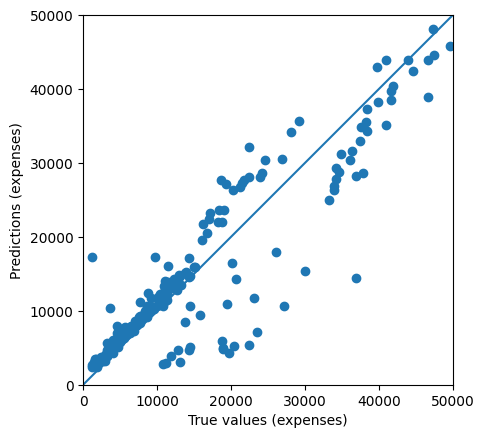

In [13]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)